# Udacity DAND Project 3 – Wrangle OpenStreetMap Data

## Introduction

In this project I will be exploring [OpenStreetMap](www.openstreetmap.org) data for central London. The data consists of XML elements classified as 'nodes' (points of interest) and 'ways' (linear features and area boundaries). Each 'node' and 'way' element can have one or more associated tags, which give further information on the feature in question. Further information on the data structure can be found here: https://wiki.openstreetmap.org/wiki/OSM_XML

Using Python scripts, I will first explore the raw XML data and audit tags that are likely to contain errors, as well as tags that I am interested in analysing in more detail. After identifying any problem areas, I will clean and export the data to CSV files, before importing it into a SQLite database. Finally, I will query the database to gain greater insight into the data, with a particular focus on shops, restaurants and places of worship. 

## Map area

The area I have chosen to analyse comprises central London, or more specifically, [TfL transport zones 1 & 2](http://content.tfl.gov.uk/standard-tube-map.pdf). 

On OpenStreetMap.org, this is the area contained within the following coordinates:
* Longitude: -0.2359 - 0.0076
* Latitude: 51.4534 - 51.5737

The map itself can be found here: https://master.apis.dev.openstreetmap.org/#map=12/51.5136/-0.1140. The underlying data can be downloaded using the Overpass API under the 'Export' option.

## Exploring and cleaning the data

Using the 'OSM_sampling.py' script provided by Udacity, I created two sample files - a large sample containing every 10th element from the original file, and a small sample containing every 1000th element. I then explored these files using code implemented in a Jupyter Notebook ('P3 - Exploring the data.ipynb'). Visualising the data this way allowed me to discover the following problems with the data, which I will explore in greater detail:  
* Abbreviated street types
* Incomplete post codes
* Inconsistent handling of "type" data
* Inconsistent handling of shop data
* Redundant data values

**Abbreviated street types**

The street type data was actually a lot cleaner and more consistent than I had anticipated. Auditing the sample files using the 'audit_address.py' script highlighted the large number (40+) of legitimate street types in London, while revealing a relatively small number of abbreviations - only `"Rd"` and `"St."`. Examples of legitimate London street types include the more typical `"Street"`, `"Avenue"`, `"Drive"` and `"Court"`, as well as the less common `"Passage"`, `"Wharf"`, `"Vale"` and `"Approach"`.

I used the following regular expression to both audit and clean the street type data:  
`street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)`

The cleaning itself was performed with the following function, which returns either the original name if valid, `None` if not, or a cleaned version of the name with the street type replaced according to a mapping as required.

```
def update_street_name(name):
    m = street_type_re.search(name)
    if m:
        if m.group() in street_type_mapping:
            startpos = name.find(m.group())
            name = name[:startpos] + street_type_mapping[m.group()]
        return name
    else:
        return None
```

**Incomplete post codes**

Similarly to the street type data, based on the number of variations on [the basic UK post code format](https://en.wikipedia.org/wiki/Postcodes_in_the_United_Kingdom#Formatting) in use in London (examples include "E9 6JQ", "W1W 6PB" and "SW1P 3PS"), I anticipated some problems here. The data however proved to be relatively clean, although there were a number of partial post codes that generally fell into one of the following categories:
* Second half of post code (i.e. following the space) missing
* Second half of post code incomplete

On the basis that the first half of the post code provides useful information to users, while the second half does not, I cleaned the post code data to remove incomplete second halves while retaining the first halves. For example, `"E1 6"` became `"E1"`. I achieved this using the following regular expressions and function:

```
post_code_re = re.compile(r'[A-Z]{1,2}\d{1,2}[A-Z]? \b\d[A-Z]{2,2}', re.IGNORECASE)
short_post_code_re = re.compile(r'[A-Z]{1,2}\d{1,2}[A-Z]?\b', re.IGNORECASE)

def update_post_code(post_code):
    if not post_code_re.match(post_code):
        m = short_post_code_re.match(post_code)
        if m:
            post_code = m.group()
        else:
            return None
    return post_code
```

**Inconsistent handling of "type" data**

The data is richly descriptive and contains a number of `"type"` tags that give further information on the relevant point of interest. However, they have not been implemented consistently, for example:

```
k="leaf_type"
k="surveillance:type"
k="tracktype"
k="type"
```
The original 'data.py' cleaning script provided by Udacity suggested treating 'k' values prefixed with a colon as subsets of a related group. For example, `k="addr:street"` and `k="addr:postcode"` could be interpreted as "street" and "postcode" data within the "addr" group. I decided to take the same approach to "type" data, and wrote a function to clean the relevant 'k' values accordingly:
```
def update_type(key):
    if ":type" in key:
         pass
    elif "_type" in key:
         key = key[:(key.find("_type"))] + ":type"
    elif "type" in key and key.find("type") != 0:
         key = key[:(key.find("type"))] + ":type"
    return key
```
Thus, any 'k' values that contain the string `"type"` and a prefix are returned with a colon separating the prefix and `"type"`. This allows the data to be categorised programmatically later in the cleaning process, with the final output being `k="type"` with a paired "category" that gives the context.

**Inconsistent handling of shop data**

As I explored the amenity data (i.e. elements with `k="amenity"`), I noticed that shops were not included in the list of amenity types. Instead, they were included as separate XML tags with `k="shop"` and values indicating the type of shop (e.g. `v="clothes"`). I felt that shops should be classed as amenities in the same way that `"bank"` and `"bureau_de_change"` were, while the `k="shop"` data should be retained as `k="shop:type"`.

To achieve this, I modified the 'data.py' processing script as follows:

```
...
if key_attrib == "shop":
    key_attrib = "shop:type"
    tag['key'] = "amenity"
    tag['value'] = "shop"
    tags.append(tag.copy())
...
```

**Redundant data vales**

Exploring the list of values produced for all the map elements with `k="amenity"`, I noticed that there were a few duplicate terms, such as:
```
"bureau_de_change",
"currency_exchange"
...
"ticket_booth",
"ticket_office"
```
There were also lists of values separated by semicolons, such as: `"learned_society;library"`. Both of these issues were also present in the (relabelled) `k="shop:type"` and `k="cuisine"` data.

Given that I wished to explore the number of the various amenities listed in the data, as well as the types of shops and cuisines served, I wanted to ensure that these variations did not obscure the analysis. Going through the list of values, I created mappings to replace the redundant terms, implemented using the following function for amenities (and similar functions for shop type and cuisines):
```
def update_amenity(value):
    if value in amenity_mapping:
        value = amenity_mapping[value]
    return value
```
I also updated the 'data.py' processing script to unpack any lists into separate tags using Python's `str.split()` function.

## Analysing the data

With the data cleaned, transferred to CSV files and loaded into a SQL database, there were a number of analyses that I wanted to perform. Specifically:
* Size of the database, in terms of bytes and elements/tags
* Number of unique contributors
  * Proportion of total contributions made by top 10 users
* Breakdown of amenities by type
  * Breakdown of cuisine(s) served
  * Breakdown of places of worship by religion
  * Breakdown of shops by type

These analyses were carried out using SQL queries (implemented through SQLite), with visualisations created using Pandas, Matplotlib and Seaborn. For the purposes of this investigation, I will be presenting only my initial findings, rather than suggesting possible explanations.

In [1]:
# Import packages and set plt and sns defaults
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pie_helper import make_labels, make_autopct
%matplotlib inline
sns.set(color_codes=True)

In [2]:
sqlite_file = 'central_london.db'

# Connect to the database and get a cursor object
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

### Database analysis

In [3]:
cursor.execute("ANALYZE;")
cursor.execute("SELECT tbl, stat FROM sqlite_stat1;")
rows = cursor.fetchall()
db_stats = pd.DataFrame(rows[::-1], columns=['Table','Stat'])
db_stats

,Table,Stat
0,nodes,1310168
1,nodes_tags,568572
2,ways,252441
3,ways_tags,931119
4,ways_nodes,1822242


In [4]:
total = 0
for row in db_stats['Stat']:
    total += int(row)

The total size of the database is 452.8MB, which is made up of 4,884,542 node/way elements and associated tags.

### User analytics

In [5]:
total_nodes_ways = int(db_stats[db_stats['Table']=='nodes']['Stat']) + \
                   int(db_stats[db_stats['Table']=='ways']['Stat'])

In [6]:
cursor.execute("SELECT uid, user, sum(count) as count FROM \
               (SELECT uid, user, count(*) as count FROM nodes GROUP BY uid \
               UNION \
               SELECT uid, user, count(*) as count FROM ways GROUP BY uid) \
               GROUP BY uid \
               ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
users = pd.DataFrame(rows, columns=['User ID', 'User', 'Count'])
percentages = (users['Count'] / total_nodes_ways * 100).round(decimals=2)
users = pd.concat([users, percentages], axis=1)
users.columns = ['User ID', 'User', 'Contributions', '% of Total']
users

,User ID,User,Contributions,% of Total
0,37137,Derick Rethans,156374,10.01
1,346,Tom Chance,128366,8.21
2,82783,Paul The Archivist,123262,7.89
3,31257,Ed Avis,96206,6.16
4,1016290,ika-chan!,88231,5.65
5,125259,abc26324,57105,3.65
6,1611,Harry Wood,43879,2.81
7,486343,peregrination,43647,2.79
8,352985,ecatmur,43608,2.79
9,64226,Blumpsy,28653,1.83


The above table shows the top 10 users by number of contributions (i.e. nodes and/or ways authored), as well as the proportion of the total number of contributions that this represents. 

In [7]:
cursor.execute("SELECT count(*) FROM \
               (SELECT uid FROM nodes GROUP BY uid \
               UNION SELECT uid FROM ways GROUP BY uid);")
rows = cursor.fetchall()
total_users = pd.DataFrame(rows, columns=['Total unique users'])
topten_contribution = sum(users['% of Total'])

We can see that the top 10 users accounted for 51.8% of total contributions, with the remainder contributed by a further 3,382 users.

### Breakdown of amenities

In [8]:
cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'amenity' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'amenity' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
amenities = pd.DataFrame(rows, columns=['Amenity', 'Count'])
amenities

,Amenity,Count
0,shop,13614
1,restaurant,3764
2,bicycle_parking,3409
3,bench,3015
4,cafe,2731
5,post_box,2117
6,parking,2064
7,pub,2007
8,telephone,1848
9,fast_food,1648


### Breakdown of cuisines served

In [9]:
cursor.execute("SELECT sum(count) FROM \
               (SELECT count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               UNION SELECT count(*) as count FROM ways_tags WHERE key = 'cuisine');")
total_cuisines = cursor.fetchone()[0]

cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'cuisine' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
cuisines = pd.DataFrame(rows, columns=['Cuisine', 'Count'])

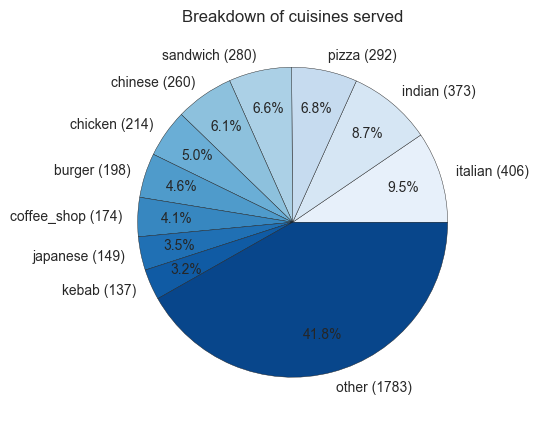

In [10]:
# Make pie chart with specific colour scheme and value labels
values = list(cuisines['Count']) + [(total_cuisines - sum(cuisines['Count']))]
categories = list(cuisines['Cuisine']) + ['other']
labels = make_labels(categories,values)
colors=sns.color_palette("Blues",11)
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, \
                                    autopct=make_autopct(values), pctdistance=0.75)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(10)
plt.title("Breakdown of cuisines served")
plt.show()

### Breakdown of places of worship by religion

In [11]:
cursor.execute("SELECT value, sum(count) FROM \
               (SELECT subq.value, count(*) as count FROM nodes_tags JOIN \
               (SELECT id, value FROM nodes_tags WHERE key = 'religion') as subq \
               ON nodes_tags.id = subq.id WHERE nodes_tags.value = 'place_of_worship' \
               GROUP BY subq.value \
               UNION \
               SELECT subq2.value, count(*) as count FROM ways_tags JOIN \
               (SELECT id, value FROM ways_tags WHERE key = 'religion') as subq2 \
               ON ways_tags.id = subq2.id WHERE ways_tags.value = 'place_of_worship' \
               GROUP BY subq2.value) \
               GROUP BY value ORDER BY count desc;")
rows = cursor.fetchall()
religions = pd.DataFrame(rows, columns=['Religion', 'Count'])

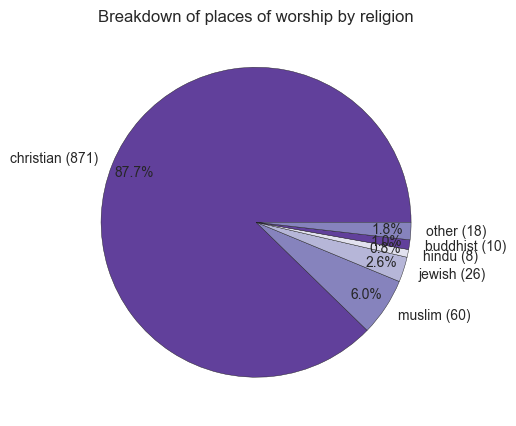

In [12]:
# Make pie chart with specific colour scheme and value labels
top_five = list(religions.loc[0:4,'Count'])
values = top_five + [sum(religions['Count'])-sum(top_five)]
categories = list(religions.loc[0:4,'Religion']) + ['other']
labels = make_labels(categories,values)
colors=sns.color_palette("Purples_r",4)
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, \
                                    autopct=make_autopct(values), pctdistance=0.85)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(10)
plt.title("Breakdown of places of worship by religion")
plt.show()

### Breakdown of shops by type

In [13]:
total_shops = int(amenities[amenities['Amenity'] == 'shop']['Count'])

cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE category = 'shop' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE category = 'shop' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
shops = pd.DataFrame(rows, columns=['Shop type', 'Count'])

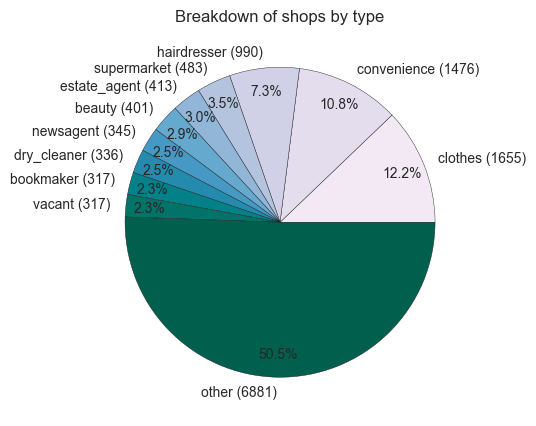

In [14]:
# Make pie chart with specific colour scheme and value labels
values = list(shops['Count']) + [(total_shops - sum(shops['Count']))]
categories = list(shops['Shop type']) + ['other']
labels = make_labels(categories,values)
colors=sns.color_palette("PuBuGn",11)
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, \
                                    autopct=make_autopct(values), pctdistance=0.85)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(10)
plt.title("Breakdown of shops by type")
plt.show()

## Additional ideas

### Analysis by location

To extend this investigation, I would like to see how my previous findings vary by location. Central London is made up of a number of neighbourhoods, each with their own set of amenities that cater to the local community. I would be interested to see how the overall breakdown of amenities varies by neighbourhood, as well as the breakdown of amenity types themselves (e.g. shops by type and restaurants by cuisine). 

To get an initial sense of how this might look, I queried the database to find the geographic distribution of shops and restaurants in the overall area being examined.

In [15]:
cursor.execute("SELECT nodes_tags.value, nodes.lat, nodes.lon FROM \
               nodes_tags JOIN nodes on nodes_tags.id = nodes.id \
               WHERE nodes_tags.value = 'shop' OR nodes_tags.value = 'restaurant';")

rows = cursor.fetchall()
locations = pd.DataFrame(rows, columns=['Amenity', 'Lat', 'Long'])
rest_locs = locations[locations['Amenity'] == 'restaurant']
shop_locs = locations[locations['Amenity'] == 'shop']

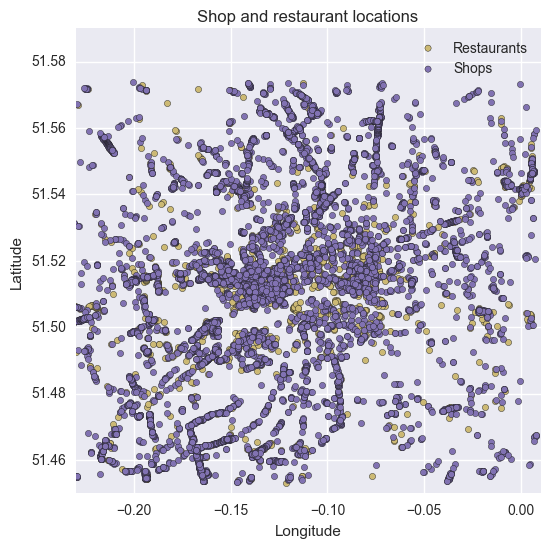

In [16]:
# Make scatter plot with axis limits and legend
plt.figure(figsize=(6,6))
plt.scatter(rest_locs['Long'], rest_locs['Lat'], c='y', label="Restaurants")
plt.scatter(shop_locs['Long'], shop_locs['Lat'], c='m', label="Shops")
plt.ylim(51.45, 51.59)
plt.xlim(-0.23, 0.01)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Shop and restaurant locations")
plt.show()

Unsurprisingly, shops and restaurants tend to be clustered in certain locations, e.g. the West End, which can be seen in the centre of the plot above. By querying the database with longitude and latitude ranges pertaining to each locale, it would be possible to perform the sort of neighbourhood-based analysis I suggest above.

### Further data improvements

While not relevant to the analyses carried out in this investigation, beyond the "type" data cleaned earlier, there are other compound 'k' tags such as `"leaf_cycle"`. To build up a comprehensive database of data sorted by relevant category, this data should be cleaned and parsed appropriately along the same lines. This may be difficult to achieve efficiently however, because underscores are used in many legitimate fields like `k="public_transport"`, where it wouldn't make sense to separate the two words in this fashion. Hence it may be necessary to clean the data based on a mapping, which would be time consuming to compile.

In [17]:
# Close the database connection
conn.close()

## Conclusion

On the whole, the OSM data for central London is very clean and holds a number of interesting insights. I would not have guessed that hairdressers would be the third most common type of shop! Among other things, it is also interesting to note that the breakdown of places of worship by religion [does not match the breakdown of religious beliefs within the Greater London population.](https://en.wikipedia.org/wiki/Religion_in_London)

To make the data more easily searchable, I believe it would be beneficial to enforce more stringent standards when it comes to some of the tag types explored in this investigation, e.g. to ensure that compound 'k' values are always prefixed by a colon to allow more simple parsing and organising of the data by users.

### List of resources

https://discussions.udacity.com/t/creating-db-file-from-csv-files-with-non-ascii-unicode-characters/174958/7  
https://www.sqlite.org/lang_altertable.html  
https://www.tutorialspoint.com/sqlite/sqlite_transactions.htm  
http://alvinalexander.com/android/sqlite-script-read-execute-how  
https://docs.python.org/2/library/sqlite3.html  
http://stackoverflow.com/questions/5244810/python-appending-a-dictionary-to-a-list-i-see-a-pointer-like-behavior  
http://stackoverflow.com/questions/23710071/how-to-join-tables-in-rows-instead-of-columns  
https://www.w3schools.com/sql/sql_union.asp  
https://www.sqlite.org/lang_analyze.html  
http://matplotlib.org/2.0.0/api/pyplot_api.html  
http://seaborn.pydata.org/tutorial/color_palettes.html   
http://seaborn.pydata.org/generated/seaborn.choose_colorbrewer_palette.html#seaborn.choose_colorbrewer_palette  
http://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct  
http://stackoverflow.com/questions/7082345/how-to-set-the-labels-size-on-a-pie-chart-in-python